# 利用Neural ODE完成MNIST手写数字识别任务

本文件是集智学园开发的“大数据驱动的人工智能”系列课程第七节课：《从深度神经网络到Neural ODE》的配套文档。在本文档中，我们将使用NeuralODE替代ResNet，作为MNIST图像识别任务的解决方案。首先将图像转换为向量表示，作为连续时间动力系统的初始状态。然后，我们可以使用Neural ODE来模拟图像像素值的连续演化，从而产生一条连续的轨迹。最后可以将轨迹的最终状态输入到一个全连接层中进行分类。

1. 准备训练数据
2. 定义 Neural ODE 网络结构
3. 任务需要的其它函数
4. 训练、测试并保存模型
5. 加载模型，查看模型功能表现

本文件是集智学园http://campus.swarma.org 出品的“大数据驱动的人工智能”系列课程第七节课的配套源代码

In [1]:
# 导入所需要的包
import os
import time
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

%matplotlib inline

isadjoint = True # 是否使用odeint_adjoint函数
if isadjoint == True:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint
    
use_cuda = torch.cuda.is_available() # 是否可以使用GPU进行计算
device = torch.device('cuda:0') if use_cuda else torch.device('cpu') # 如果可以使用GPU，则使用GPU；否则使用CPU

## 一、准备训练数据

这段代码是利用PyTorch中的DataLoader加载MNIST数据集，并对数据进行了预处理。其中，train_loader是训练数据加载器，train_eval_loader和test_loader是测试数据加载器，它们分别对应训练集和测试集。
transforms参数定义了对数据进行的转换，包括将数据转换为张量和进行标准化。
batch_size参数定义了每个批次包含的数据量，shuffle参数表示每个epoch是否打乱数据顺序，num_workers参数表示用于数据加载的子进程数量，drop_last参数表示是否丢弃最后一个不完整的批次。

本文件是集智学园http://campus.swarma.org 出品的“大数据驱动的人工智能”系列课程第七节课的配套源代码。

In [2]:
best_acc = 0 # 初始准确率
lr = 0.1 # 学习率
test_batch_size = 1000 # 测试集的 batch_size 大小
batch_size = 128 # 训练集的 batch_size 大小
nepochs = 5 # 定义训练迭代的次数

In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data',train=True,download=True, # 下载并加载MNIST数据集，train=True表示使用训练集
                  transform=transforms.Compose([ # 定义数据转换的方式
                      transforms.ToTensor(), # 将数据转换为PyTorch张量
                      transforms.Normalize((0.1307,),(0.3081,)) # 数据标准化
                  ])),
    batch_size = batch_size,shuffle=True, num_workers=2, drop_last=True) # 定义数据加载器的参数

train_eval_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data',train=False,download=True, # train=False表示使用测试集
                  transform=transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize((0.1307,),(0.3081,))
                  ])),
    batch_size = test_batch_size,shuffle=False, num_workers=2, drop_last=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data',train=False,download=True, # train=False表示使用测试集
                  transform=transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize((0.1307,),(0.3081,))
                  ])),
    batch_size = test_batch_size,shuffle=False, num_workers=2, drop_last=True)

batches_per_epoch = len(train_loader)//4 # 一个epoch包含的批次数

## 二、定义Neural ODE网络结构

这段代码定义了三个继承自nn.Module的类：ConcatConv2d、ODEfunc和ODEBlock，分别用于定义一个拼接卷积层、ODE函数和ODE块。其中ConcatConv2d类的实例对象是一个卷积层，输入和输出通道数相同，可以提取特征。ODEfunc类的实例对象是一个ODE函数，包含多个拼接卷积层，并在其中加入了BatchNorm2d操作、ReLU激活函数等，用于归一化数据并激活输出结果。ODEBlock类的实例对象是一个ODE块，将ODE函数作为参数输入，在该块中进行ODE求解并返回结果。同时，该代码还定义了一个Flatten类，用于将输入数据展平。

本文件是集智学园http://campus.swarma.org 出品的“大数据驱动的人工智能”系列课程第七节课的配套源代码。

In [4]:
# 定义一个继承自nn.Module的类ConcatConv2d
class ConcatConv2d(nn.Module): 
    # 初始化函数，用于初始化类的各个成员变量
    def __init__(self, dim_in, dim_out, ksize=3, stride=1, padding=0, dilation=1, groups=1, bias=True, transpose=False): 
        super(ConcatConv2d, self).__init__() 
        # 调用nn.ConvTranspose2d或nn.Conv2d构造卷积层，根据transpose决定用哪个类
        module = nn.ConvTranspose2d if transpose else nn.Conv2d 
        # 将构造出来的卷积层保存在_layer成员变量中
        self._layer = module( 
            dim_in + 1, dim_out, kernel_size=ksize, stride=stride, padding=padding, dilation=dilation, groups=groups,
            bias=bias
        )
        
    # forward函数用于计算模型的前向传播结果
    def forward(self, t, x): 
        # 将t和x在通道维上拼接起来，得到新的输入
        tt = torch.ones_like(x[:, :1, :, :]) * t 
        ttx = torch.cat([tt, x], 1)
        # 将拼接后的输入传入卷积层，得到输出结果
        return self._layer(ttx)
    
# 定义一个继承自nn.Module的类ODEfunc
class ODEfunc(nn.Module):
    # 初始化函数，定义了网络结构
    def __init__(self, dim):
        super(ODEfunc, self).__init__()
        self.norm1 =  nn.BatchNorm2d(dim) # BatchNorm2d操作，用于归一化输入数据
        self.relu = nn.ReLU(inplace=True) # ReLU激活函数，inplace=True表示直接覆盖原数据，节省内存
        self.conv1 = ConcatConv2d(dim, dim, 3, 1, 1) # 自定义的卷积层，输入通道数和输出通道数都为dim，卷积核大小为3，padding=1，用于提取特征
        self.norm2 =  nn.BatchNorm2d(dim) # BatchNorm2d操作，用于归一化输入数据
        self.conv2 = ConcatConv2d(dim, dim, 3, 1, 1)
        self.norm3 =  nn.BatchNorm2d(dim)
        self.nfe = 0 # nfe表示网络前向传播的次数
    
    # 前向传播方法，输入数据x在网络中前向传播得到输出结果
    def forward(self, t, x):
        self.nfe += 1 # 前向传播次数加1
        out = self.norm1(x) # 数据归一化
        out = self.relu(out) # 激活函数ReLU
        out = self.conv1(t, out) # 卷积操作
        out = self.norm2(out) 
        out = self.relu(out) 
        out = self.conv2(t, out) 
        out = self.norm3(out) # 
        return out # 返回输出结果

# 定义一个继承自nn.Module的类ODEBlock
class ODEBlock(nn.Module):
    
    # 初始化函数
    def __init__(self, odefunc):
        super(ODEBlock, self).__init__()
        self.odefunc = odefunc # 指定ODE函数
        self.integration_time = torch.tensor([0, 1]).float() # 积分时间，定义为0到1的浮点数

    def forward(self, x):
        self.integration_time = self.integration_time.type_as(x) # 将积分时间的数据类型转换为输入数据x的数据类型
        out = odeint(self.odefunc, x, self.integration_time, rtol = 1e-3, atol = 1e-3) # 进行ODE求解，得到输出结果out
        return out[1] # 只返回积分时间的最后一个时间点的输出结果
    
    # 获取ODE函数中的前向传播次数
    def nfe(self):
        return self.odefunc.nfe
    
    # 设置ODE函数中的前向传播次数
    def nfe(self, value):
        self.odefunc.nfe = value
        
class Flatten(nn.Module):
    # 初始化函数
    def __init__(self):
        super(Flatten, self).__init__()
    # 前向传播方法，输入数据x在网络中前向传播得到输出结果
    def forward(self, x):
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        return x.view(-1, shape)

这段代码定义了一个卷积神经网络模型，包含三个部分：下采样层、特征提取层和全连接层。特征提取层的实现可以根据标记变量is_odenet的值选择使用 OdeNet 或者 ResNet，下采样层和全连接层不受影响。模型最终将各层组合成一个神经网络模型，并将模型移动到指定设备上（如GPU）。

本文件是集智学园http://campus.swarma.org 出品的“大数据驱动的人工智能”系列课程第七节课的配套源代码。

In [5]:
is_odenet = True # 标记特征提取层是否使用 OdeNet，True 表示使用 OdeNet，False表示使用 ResNet
downsampling_layers = [ #下采样层
            nn.Conv2d(1, 64, 3, 1), # 卷积层
            nn.BatchNorm2d(64), # 批归一化层
            nn.ReLU(inplace=True), # 激活函数
            nn.Conv2d(64, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 4, 2, 1),
        ]

feature_layers = [ODEBlock(ODEfunc(64))] if is_odenet else [ResBlock(64, 64) for _ in range(6)] # 特征提取层

fc_layers = [ nn.BatchNorm2d(64), nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d((1, 1)), Flatten(), nn.Linear(64, 10)] # 全连接层

model = nn.Sequential(*downsampling_layers, *feature_layers, *fc_layers).to(device) # 将各层组合成一个模型

## 三、任务需要的其它函数

这段代码包含两个函数：
accuracy(model, dataset_loader)：用于计算给定数据集加载器上模型的准确率。它遍历数据集加载器中的所有数据样本，将数据样本输入模型进行预测，并将预测结果与真实标签进行比较，以计算正确分类的样本数。最终，该函数返回准确率。
inf_generator(iterable)：用于将一个可迭代对象转换为一个无限循环的迭代器。它创建一个可迭代对象的迭代器，并使用无限循环来不断返回迭代器的下一个元素，直到迭代器的结尾。如果已经到达迭代器的结尾，该函数将重新创建一个可迭代对象的迭代器，从头开始迭代，以便可以继续无限循环。

本文件是集智学园http://campus.swarma.org 出品的“大数据驱动的人工智能”系列课程第七节课的配套源代码。

In [8]:
# 计算模型在给定数据集加载器上的准确率
def accuracy(model, dataset_loader):
    total_correct = 0
    for x, y in dataset_loader:
        x = x.to(device)
        # 将标签y编码为 one-hot 格式
        y = np.array(np.array(y.numpy())[:, None] == np.arange(10)[None, :], dtype=int)
        # 提取目标类别和预测类别
        target_class = np.argmax(y, axis=1)
        predicted_class = np.argmax(model(x).cpu().detach().numpy(), axis=1)
        # 统计正确分类的样本数
        total_correct += np.sum(predicted_class == target_class)
        
    # 计算准确率
    return total_correct / len(dataset_loader.dataset)

# 将一个可迭代对象，转换为一个无限循环的迭代器。
def inf_generator(iterable):
    iterator = iterable.__iter__() # 创建一个可迭代对象的迭代器
    while True:
        try:
            yield iterator.__next__() # 返回迭代器的下一个元素
        except StopIteration: # 如果已经到达迭代器的结尾
            iterator = iterable.__iter__() # 重新创建一个可迭代对象的迭代器，从头开始迭代

## 四、训练、测试并保存模型

这段代码是迭代训练神经网络的过程，在每个epoch中，训练更新模型参数。每个epoch训练完成后，计算训练集和测试集上的准确率，并记录最好的模型。
打印训练集准确率和测试集准确率。画出loss曲线。

本文件是集智学园http://campus.swarma.org 出品的“大数据驱动的人工智能”系列课程第七节课的配套源代码。

In [7]:
end0 = time.time() # 记录开始时间
Loss_list = [] # 用于记录每次迭代的loss
optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9) # 定义随机梯度下降（SGD）优化器，用于更新模型参数，设置学习率和动量
criterion = nn.CrossEntropyLoss().to(device) # 定义交叉熵损失函数，用于计算模型的误差，将其移动到设备（CPU或GPU）上

for itr in range(nepochs * batches_per_epoch * 4):
    
    optimizer.zero_grad() # 梯度清零
    
    x, y = inf_generator(train_loader).__next__() # 获取训练数据及标签
    
    x = x.to(device) # 将训练数据移到GPU上
    y = y.to(device) # 将标签移到GPU上
    logits = model(x) # 计算预测值
    loss = criterion(logits, y) # 计算loss

    if is_odenet: # 如果是ODENet网络结构，记录调用前向计算函数的次数
        nfe_forward = feature_layers[0].nfe
        feature_layers[0].nfe = 0 # 重置前向计算函数的调用次数

    loss.backward() # 反向传播计算梯度
    optimizer.step() # 更新网络参数

    if is_odenet: # 如果是ODENet网络结构，记录后向计算函数的调用次数
        nfe_backward = feature_layers[0].nfe
        feature_layers[0].nfe = 0 # 重置后向计算函数的调用次数

    # 每训练完一个 epochs，就计算一次模型在训练集和测试集上的准确率，选取最好的模型保存
    if itr % batches_per_epoch == 0:
        with torch.no_grad():
            Loss_list.append(loss.item()) # 记录loss
            train_acc = accuracy(model, train_eval_loader) # 计算训练集上的准确率
            val_acc = accuracy(model, test_loader) # 计算测试集上的准确率
            if val_acc > best_acc: # 如果测试集上的准确率比之前记录的最好结果还要好
                torch.save(model.state_dict(), 'model.pth') # 就保存当前模型
                best_acc = val_acc # 更新最好的准确率
            end1 = time.time() # 记录结束时间
            print("Epoch {:04d} | Loss {:.3f} | Time {:.3f}min  ".format(itr // batches_per_epoch, loss.item(),(end1 - end0)/60.0))
            
            #print("Epoch {:04d} | Loss {:.3f} | Time {:.3f}min | nfe_forward {:02d} | nfe_backward {:02d} ".format(itr // batches_per_epoch, loss.item(),(end1 - end0)/60.0, nfe_forward, nfe_backward))
            print("Train Acc {:.4f} | Test Acc {:.4f}".format(train_acc, val_acc)) # 打印训练集准确率和测试集准确率
            print(" ")
            
            end0 = end1 # 更新开始时间

Epoch 0000 | Loss 2.318 | Time 0.109min  
Train Acc 0.1180 | Test Acc 0.1180
 
Epoch 0001 | Loss 0.170 | Time 1.034min  
Train Acc 0.9631 | Test Acc 0.9631
 
Epoch 0002 | Loss 0.062 | Time 1.034min  
Train Acc 0.9790 | Test Acc 0.9790
 
Epoch 0003 | Loss 0.032 | Time 1.031min  
Train Acc 0.9832 | Test Acc 0.9832
 
Epoch 0004 | Loss 0.030 | Time 1.032min  
Train Acc 0.9870 | Test Acc 0.9870
 
Epoch 0005 | Loss 0.045 | Time 1.030min  
Train Acc 0.9856 | Test Acc 0.9856
 
Epoch 0006 | Loss 0.055 | Time 1.180min  
Train Acc 0.9903 | Test Acc 0.9903
 
Epoch 0007 | Loss 0.003 | Time 1.219min  
Train Acc 0.9891 | Test Acc 0.9891
 
Epoch 0008 | Loss 0.018 | Time 1.226min  
Train Acc 0.9897 | Test Acc 0.9897
 
Epoch 0009 | Loss 0.003 | Time 1.219min  
Train Acc 0.9896 | Test Acc 0.9896
 
Epoch 0010 | Loss 0.005 | Time 1.216min  
Train Acc 0.9909 | Test Acc 0.9909
 
Epoch 0011 | Loss 0.029 | Time 1.212min  
Train Acc 0.9897 | Test Acc 0.9897
 
Epoch 0012 | Loss 0.027 | Time 1.217min  
Train Acc 

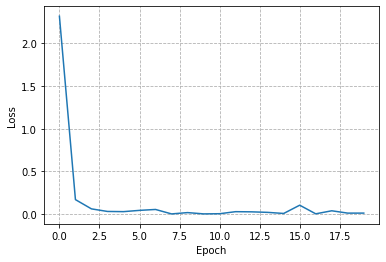

In [9]:
# 绘制Loss值随训练次数的变化曲线
plt.plot(Loss_list)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid(ls = '--')
plt.show()

## 五、加载模型，查看模型功能表现

定义相同结构的NeuralODE模型，加载刚保存的预训练模型参数。对数据加载器 performance_loader 中的每个 batch，使用 plt.imshow 显示其中的 5 个图像；使用 model 对 performance_loader 中的图像进行识别，并输出识别结果。

本文件是集智学园http://campus.swarma.org 出品的“大数据驱动的人工智能”系列课程第七节课的配套源代码。

In [10]:
is_odenet = True # 标记特征提取层是否使用 OdeNet，True 表示使用 OdeNet，False表示使用 ResNet
downsampling_layers = [ #下采样层
            nn.Conv2d(1, 64, 3, 1), # 卷积层
            nn.BatchNorm2d(64), # 批归一化层
            nn.ReLU(inplace=True), # 激活函数
            nn.Conv2d(64, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 4, 2, 1),
        ]

feature_layers = [ODEBlock(ODEfunc(64))] if is_odenet else [ResBlock(64, 64) for _ in range(6)] # 特征提取层

fc_layers = [ nn.BatchNorm2d(64), nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d((1, 1)), Flatten(), nn.Linear(64, 10)] # 全连接层

model = nn.Sequential(*downsampling_layers, *feature_layers, *fc_layers).to(device) # 将各层组合成一个模型
model.cuda().load_state_dict(torch.load('model.pth')) #加载模型参数

<All keys matched successfully>

输入模型的数字：


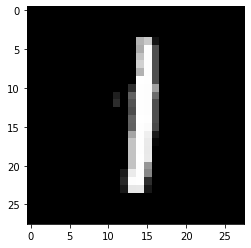

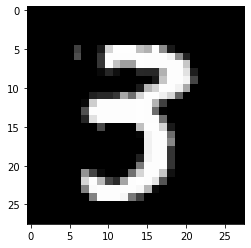

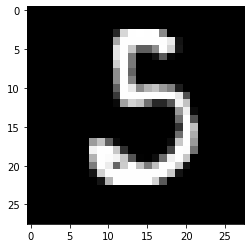

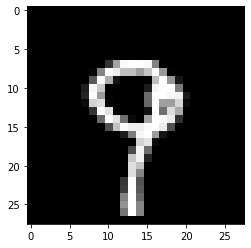

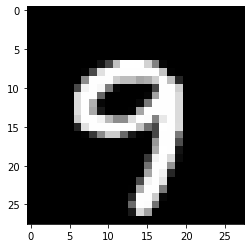

模型识别的结果：
[1 3 5 9 9]


In [13]:
# 用于显示模型性能的数据加载器 performance_loader
performance_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data',train=False,download=True, 
                  transform=transforms.Compose([
                      transforms.ToTensor()
                  ])),
    batch_size = 5,shuffle=True, num_workers=2, drop_last=True)

print("输入模型的数字：")
for x,y in performance_loader:
    for i in range(5):
        # 显示当前 batch 中的第 i 个图像
        plt.imshow(x[i,:,:,:].unsqueeze(1).squeeze(), cmap='gray')
        plt.show()
    break # 只显示一个 batch 中的图像

print("模型识别的结果：")
print(np.argmax(model(x.cuda()).cpu().detach().numpy(), axis=1)) # 输出模型对一个 batch 中图像的识别结果